<a href="http://cocl.us/pytorch_link_top">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/Pytochtop.png" width="750" alt="IBM Product " />
</a> 

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/cc-logo-square.png" width="200" alt="cognitiveclass.ai logo" />

<h1>Linear Regression Multiple Outputs</h1> 

<h2>Table of Contents</h2>
<p>In this lab, you will create a model the PyTroch way. This will help you more complicated models.</p>

<ul>
    <li><a href="#Makeup_Data">Make Some Data</a></li>
    <li><a href="#Model_Cost">Create the Model and Cost Function the PyTorch way</a></li>
    <li><a href="#BGD">Train the Model: Batch Gradient Descent</a></li>
</ul>
<p>Estimated Time Needed: <strong>20 min</strong></p>

<hr>

<h2>Preparation</h2>

We'll need the following libraries:

In [1]:
# Import the libraries we need for this lab

from torch import nn,optim
import torch
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from torch.utils.data import Dataset, DataLoader

Set the random seed:

In [2]:
# Set the random seed to 1. 

torch.manual_seed(1)

Use this function for plotting: 

In [3]:
# The function for plotting 2D

def Plot_2D_Plane(model, dataset, n=0):
    w1 = model.state_dict()['linear.weight'].numpy()[0][0]
    w2 = model.state_dict()['linear.weight'].numpy()[0][1]
    b = model.state_dict()['linear.bias'].numpy()

    # Data
    x1 = data_set.x[:, 0].view(-1, 1).numpy()
    x2 = data_set.x[:, 1].view(-1, 1).numpy()
    y = data_set.y.numpy()

    # Make plane
    X, Y = np.meshgrid(np.arange(x1.min(), x1.max(), 0.05), np.arange(x2.min(), x2.max(), 0.05))
    yhat = w1 * X + w2 * Y + b

    # Plotting
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    ax.plot(x1[:, 0], x2[:, 0], y[:, 0],'ro', label='y') # Scatter plot
    
    ax.plot_surface(X, Y, yhat) # Plane plot
    
    ax.set_xlabel('x1 ')
    ax.set_ylabel('x2 ')
    ax.set_zlabel('y')
    plt.title('estimated plane iteration:' + str(n))
    ax.legend()

    plt.show()

<!--Empty Space for separating topics-->

<h2 id=" #Makeup_Data" > Make Some Data </h2>

Create a dataset class with two-dimensional features:

In [8]:
x = torch.zeros(20, 2)
x[:, 0] = torch.arange(-1, 1, 0.1)
x[:, 1] = torch.arange(-1, 1, 0.1)
x

tensor([[-1.0000, -1.0000],
        [-0.9000, -0.9000],
        [-0.8000, -0.8000],
        [-0.7000, -0.7000],
        [-0.6000, -0.6000],
        [-0.5000, -0.5000],
        [-0.4000, -0.4000],
        [-0.3000, -0.3000],
        [-0.2000, -0.2000],
        [-0.1000, -0.1000],
        [ 0.0000,  0.0000],
        [ 0.1000,  0.1000],
        [ 0.2000,  0.2000],
        [ 0.3000,  0.3000],
        [ 0.4000,  0.4000],
        [ 0.5000,  0.5000],
        [ 0.6000,  0.6000],
        [ 0.7000,  0.7000],
        [ 0.8000,  0.8000],
        [ 0.9000,  0.9000]])

In [11]:
x.shape[0],1

(20, 1)

In [13]:
torch.randn(x.shape[0],1)

tensor([[-1.5256],
        [-0.7502],
        [-0.6540],
        [-1.6095],
        [ 0.8657],
        [ 0.2444],
        [-0.6629],
        [ 0.8073],
        [ 0.4391],
        [ 1.1712],
        [ 1.7674],
        [-0.0954],
        [ 0.0612],
        [-0.6177],
        [-0.7981],
        [-0.1316],
        [-0.7984],
        [ 0.3357],
        [ 0.2753],
        [ 1.7163]])

In [14]:
# Create a 2D dataset

class Data2D(Dataset):
    
    # Constructor
    def __init__(self):
        #20 datapoints and 2 x values per
        self.x = torch.zeros(20, 2)
        self.x[:, 0] = torch.arange(-1, 1, 0.1)
        self.x[:, 1] = torch.arange(-1, 1, 0.1)
        #initial weight for each X
        self.w = torch.tensor([[1.0], [1.0]])
        #ad one bias
        self.b = 1
        
        #function
        self.f = torch.mm(self.x, self.w) + self.b    
        
        #Y with some noise it looks like
        self.y = self.f + 0.1 * torch.randn((self.x.shape[0],1))
        self.len = self.x.shape[0]

    # Getter
    def __getitem__(self, index):          
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len

Create a dataset object:

In [15]:
# Create the dataset object

data_set = Data2D()

<h2 id="Model_Cost">Create the Model, Optimizer, and Total Loss Function (Cost)</h2>

Create a customized linear regression module: 

In [16]:
# Create a customized linear

class linear_regression(nn.Module):
    
    # Constructor
    def __init__(self, input_size, output_size):
        super(linear_regression, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        
    # Prediction
    def forward(self, x):
        yhat = self.linear(x)
        return yhat

Create a model. Use two features: make the input size 2 and the output size 1: 

In [17]:
# Create the linear regression model and print the parameters

model = linear_regression(2,1)
print("The parameters: ", list(model.parameters()))

The parameters:  [Parameter containing:
tensor([[0.3454, 0.0403]], requires_grad=True), Parameter containing:
tensor([0.2322], requires_grad=True)]


Create an optimizer  object. Set the learning rate to 0.1. <b>Don't forget to enter the model parameters in the constructor.</b>

<img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/chapter2/2.6.2paramater_hate.png" width = "100" alt="How the optimizer works" />

In [18]:
# Create the optimizer

optimizer = optim.SGD(model.parameters(), lr=0.1)

Create the criterion function that calculates the total loss or cost:

In [19]:
# Create the cost function

criterion = nn.MSELoss()

Create a data loader object. Set the batch_size equal to 2: 

In [20]:
# Create the data loader

#go through batches of two at a time
train_loader = DataLoader(dataset=data_set, batch_size=2)

<!--Empty Space for separating topics-->

<h2 id="BGD">Train the Model via Mini-Batch Gradient Descent</h2>

Run 100 epochs of Mini-Batch Gradient Descent and store the total loss or cost for every iteration. Remember that this is an approximation of the true total loss or cost:

Before Training: 


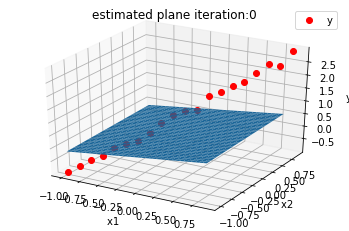

tensor([[-1.0000, -1.0000],
        [-0.9000, -0.9000]]) tensor([[-0.9801],
        [-0.7954]])
tensor([[-0.8000, -0.8000],
        [-0.7000, -0.7000]]) tensor([[-0.5847],
        [-0.4476]])
tensor([[-0.6000, -0.6000],
        [-0.5000, -0.5000]]) tensor([[-0.1785],
        [-0.0524]])
tensor([[-0.4000, -0.4000],
        [-0.3000, -0.3000]]) tensor([[0.0197],
        [0.2692]])
tensor([[-0.2000, -0.2000],
        [-0.1000, -0.1000]]) tensor([[0.6453],
        [0.9142]])
tensor([[0.0000, 0.0000],
        [0.1000, 0.1000]]) tensor([[1.0249],
        [1.0225]])
tensor([[0.2000, 0.2000],
        [0.3000, 0.3000]]) tensor([[1.5117],
        [1.6298]])
tensor([[0.4000, 0.4000],
        [0.5000, 0.5000]]) tensor([[1.8110],
        [1.9354]])
tensor([[0.6000, 0.6000],
        [0.7000, 0.7000]]) tensor([[2.2429],
        [2.5476]])
tensor([[0.8000, 0.8000],
        [0.9000, 0.9000]]) tensor([[2.4213],
        [2.9610]])
tensor([[-1.0000, -1.0000],
        [-0.9000, -0.9000]]) tensor([[-0.9801]

limit_output extension: Maximum message size of 10000 exceeded with 17957 characters

In [21]:
# Train the model

LOSS = []
print("Before Training: ")
Plot_2D_Plane(model, data_set)   
epochs = 100
   
def train_model(epochs):    
    for epoch in range(epochs):
        for x,y in train_loader:
            print(x,y)
            yhat = model(x)
            loss = criterion(yhat, y)
            LOSS.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()     
train_model(epochs)
print("After Training: ")
Plot_2D_Plane(model, data_set, epochs)  

Text(0, 0.5, 'Cost/total loss ')

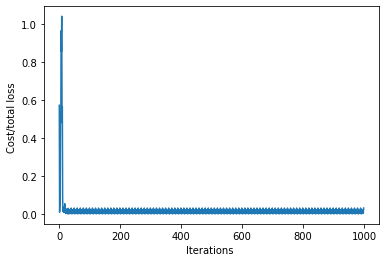

In [22]:
# Plot out the Loss and iteration diagram

plt.plot(LOSS)
plt.xlabel("Iterations ")
plt.ylabel("Cost/total loss ")

<h3>Practice</h3>

Create a new <code>model1</code>. Train the model with a batch size 30 and learning rate 0.1, store the loss or total cost in a list <code>LOSS1</code>, and plot the results.

The parameters:  [Parameter containing:
tensor([[ 0.2641, -0.0482]], requires_grad=True), Parameter containing:
tensor([-0.1832], requires_grad=True)]
Before Training: 


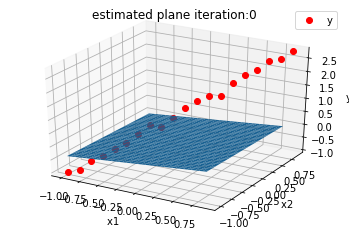

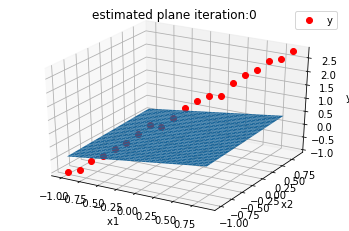

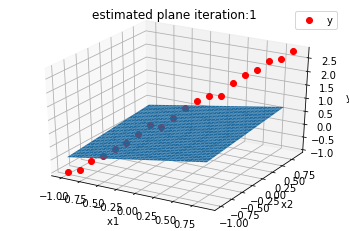

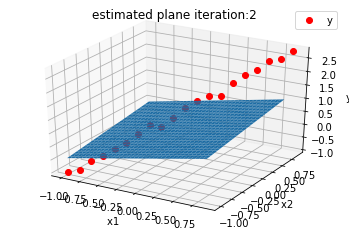

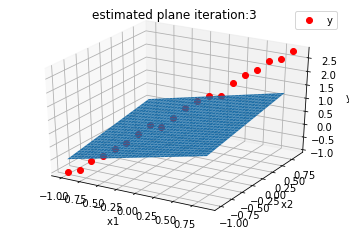

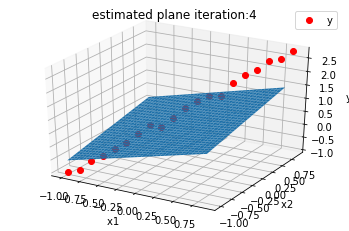

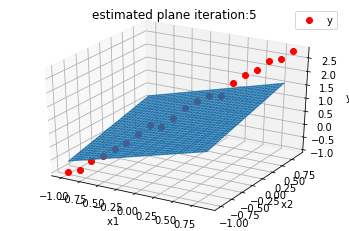

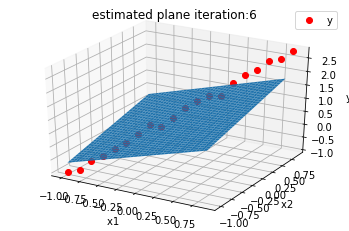

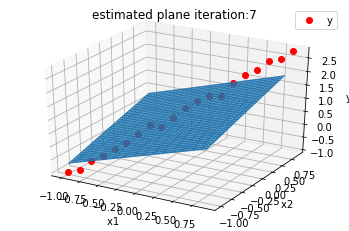

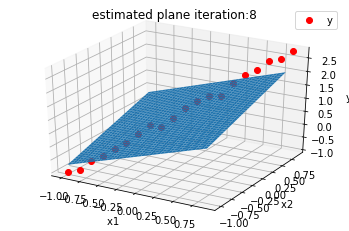

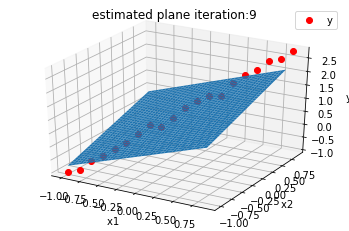

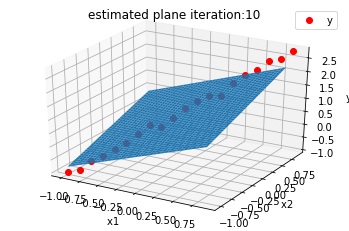

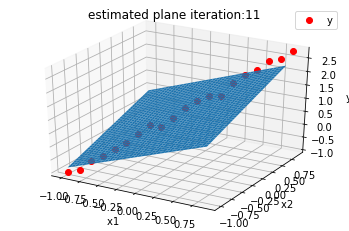

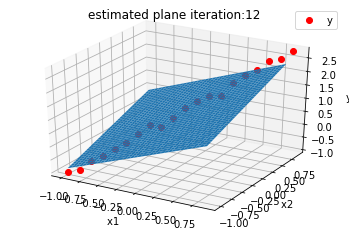

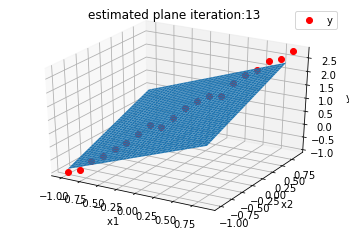

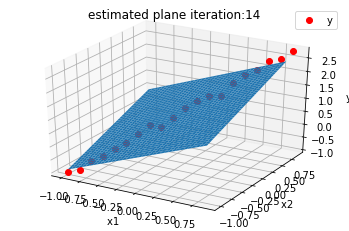

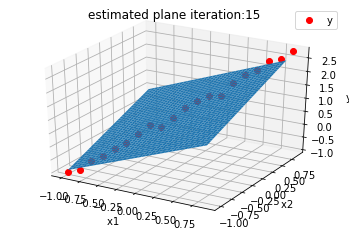

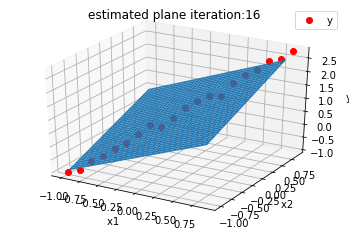

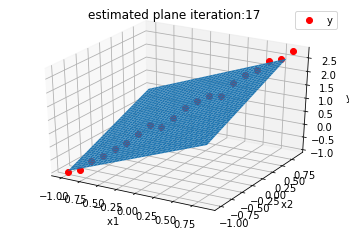

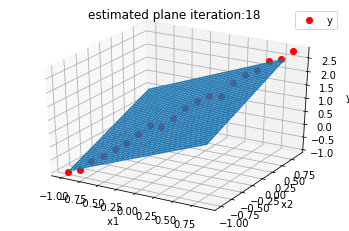

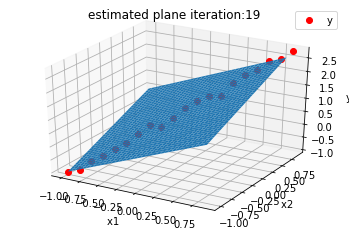

After Training: 


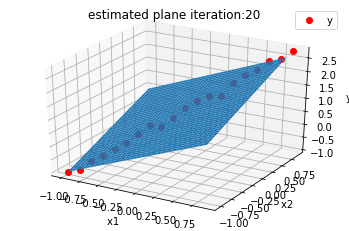

In [26]:
# Practice create model1. Train the model with batch size 30 and learning rate 0.1, store the loss in a list <code>LOSS1</code>. Plot the results.
# Create the linear regression model and print the parameters

model = linear_regression(2,1)
print("The parameters: ", list(model.parameters()))
optimizer = optim.SGD(model.parameters(), lr=0.1)
criterion = nn.MSELoss()
data_set = Data2D()
train_loader = DataLoader(dataset=data_set, batch_size=30)

LOSS2 = []
print("Before Training: ")
Plot_2D_Plane(model, data_set)   
epochs = 20
   
def train_model(epochs):    
    for epoch in range(epochs):
        for x,y in train_loader:
            #print(x,y)
            yhat = model(x)
            loss = criterion(yhat, y)
            LOSS2.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        Plot_2D_Plane(model, data_set, epoch)
train_model(epochs)
print("After Training: ")
Plot_2D_Plane(model, data_set, epochs)  

Double-click <b>here</b> for the solution.

<!-- Your answer is below:
train_loader = DataLoader(dataset = data_set, batch_size = 30)
model1 = linear_regression(2, 1)
optimizer = optim.SGD(model1.parameters(), lr = 0.1)
LOSS1 = []
epochs = 100
def train_model(epochs):    
    for epoch in range(epochs):
        for x,y in train_loader:
            yhat = model1(x)
            loss = criterion(yhat,y)
            LOSS1.append(loss.item())
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()     
train_model(epochs)
Plot_2D_Plane(model1 , data_set)  
plt.plot(LOSS1)
plt.xlabel("iterations ")
plt.ylabel("Cost/total loss ")
-->



Use the following validation data to calculate the total loss or cost for both models:

-Important

In [27]:
torch.manual_seed(2)

validation_data = Data2D()
Y = validation_data.y
X = validation_data.x
criterion(model(X),Y)

tensor(0.0148, grad_fn=<MseLossBackward>)

Double-click <b>here</b> for the solution.
<!-- Your answer is below:
print("total loss or cost for model: ",criterion(model(X),Y))
print("total loss or cost for model: ",criterion(model1(X),Y))
-->

<!--Empty Space for separating topics-->

<a href="http://cocl.us/pytorch_link_bottom">
    <img src="https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/DL0110EN/notebook_images%20/notebook_bottom%20.png" width="750" alt="PyTorch Bottom" />
</a>

<h2>About the Authors:</h2> 

<a href="https://www.linkedin.com/in/joseph-s-50398b136/">Joseph Santarcangelo</a> has a PhD in Electrical Engineering, his research focused on using machine learning, signal processing, and computer vision to determine how videos impact human cognition. Joseph has been working for IBM since he completed his PhD. 

Other contributors: <a href="https://www.linkedin.com/in/michelleccarey/">Michelle Carey</a>, <a href="www.linkedin.com/in/jiahui-mavis-zhou-a4537814a">Mavis Zhou</a>

<hr>

Copyright &copy; 2018 <a href="cognitiveclass.ai?utm_source=bducopyrightlink&utm_medium=dswb&utm_campaign=bdu">cognitiveclass.ai</a>. This notebook and its source code are released under the terms of the <a href="https://bigdatauniversity.com/mit-license/">MIT License</a>.